In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import sparse

%matplotlib inline

# Лабораторная работа 4

### Экстраполяция населения страны

- Классическая полиномиальная интерполяция по Ньютону
- Сплайн-интерполяция
- Метод наименьших квадратов

### Население США

| Год  | Население   |
|------|-------------|
| 1910 | 92 228 496  |
| 1920 | 106 021 537 |
| 1930 | 123 202 624 |
| 1940 | 132 164 569 |
| 1950 | 151 325 798 |
| 1960 | 179 323 175 |
| 1970 | 203 211 926 |
| 1980 | 226 545 805 |
| 1990 | 248 709 873 |
| 2000 | 281 421 906 |
| 2010 | 308 745 538 |

### Входные данные ###

In [ ]:
years = np.arange(1910, 2010, 10)
n = len(years)
population = np.array([92228496,
                  106021537,
                  123202624,
                  132164569,
                  151325798,
                  179323175,
                  203211926,
                  226545805,
                  248709873,
                  281421906])

# Классическая полиномиальная интерполяция по Ньютону #

In [ ]:
class Newton_Polynomial:
    # Initialize class variables
    def __init__(self, x, f):
        self.x = x.copy()
        self.f = f.copy()
        self.c = self.coefficients()

    # Count the value of Newton's polynomial in exact point
    def __call__(self, x_0):
        n = len(self.x)
        L = self.c[0]
        mult = 1.0

        # Calculate value of the polynomial
        for x_i, c_i in zip(self.x[:(n-1)], self.c[1:]):
            mult *= (x_0 - x_i)
            L += mult * c_i

        return L

    def coefficients(self):
        # Create an empty table of a size [n x n]
        n = len(self.x)
        table = np.empty([n, n])

        # Count the divided differences and fill the table
        table[0] = self.f
        for i in range(1, n):
            for j in range(n-i):
                table[i][j] = (table[i-1][j+1] - table[i-1][j]) / (self.x[j+i] - self.x[j])

        return [table[i, 0] for i in range(n)]

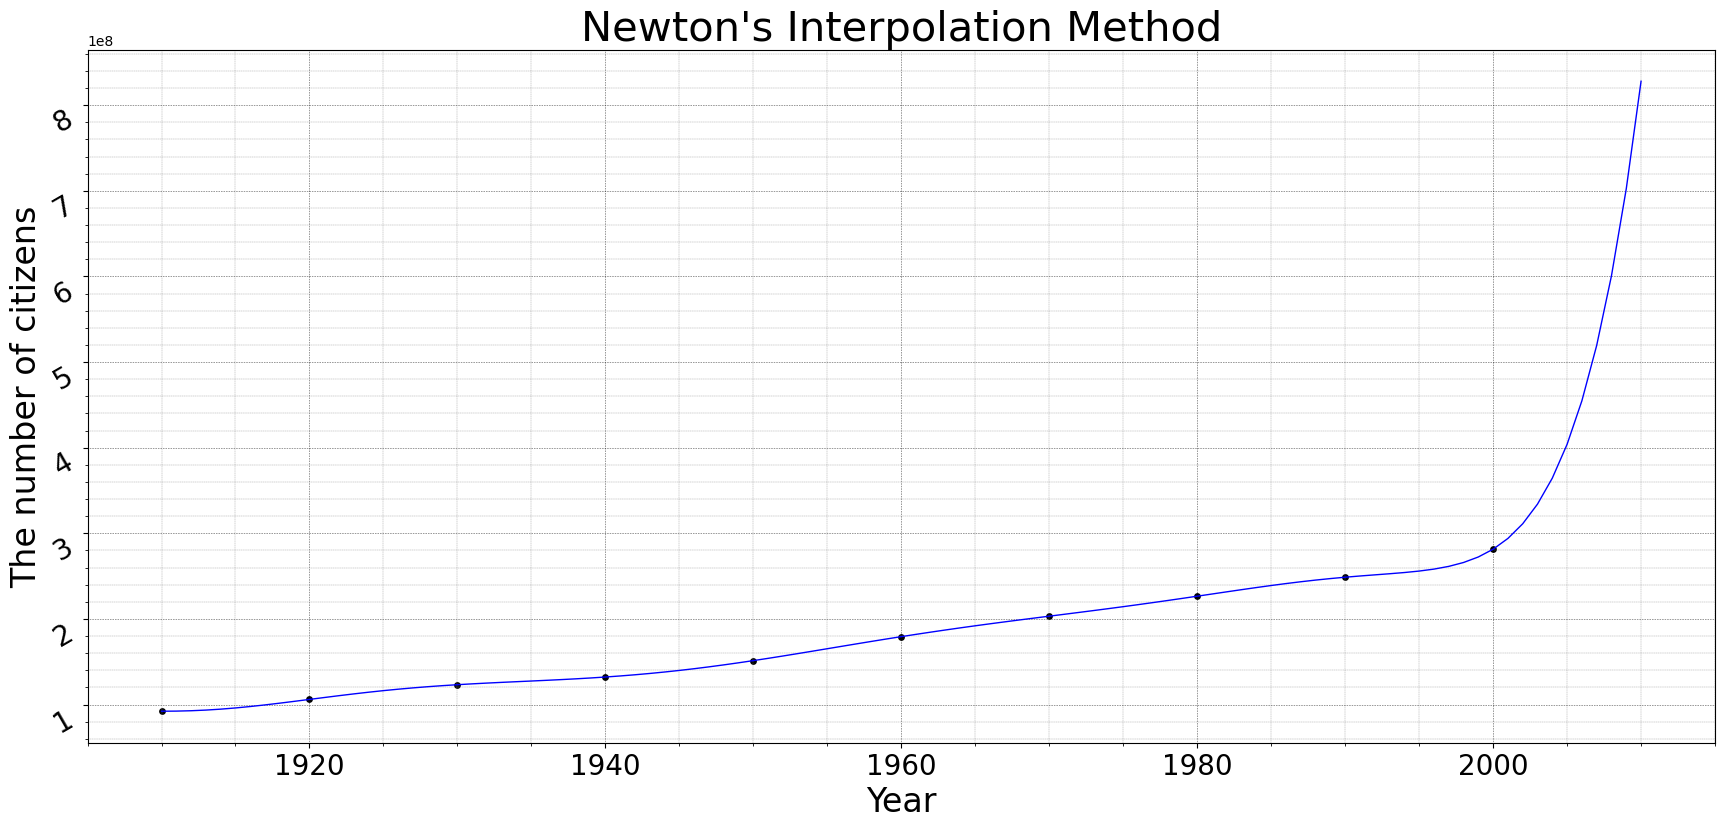

Population of the USA in 2010: 827906509.0000029


In [ ]:
plt.figure(figsize = [21, 9])
plt.title("Newton's Interpolation Method", fontsize = 30)

plt.xlabel("Year", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("The number of citizens", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(years, population, s = 15, color = "black")

x = np.arange(years[0], years[n - 1] + 11)
polynomial = Newton_Polynomial(years, population)
plt.plot(x, polynomial(x), color='blue', linewidth = 1)

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

plt.show()

print(f"Population of the USA in 2010: {polynomial(2010)}")

### По результатам интерполяции, население США к 2010 году должно было составлять 827.906.509 человек, в то время как в реальности оно составило 308.745.538. ###

# Сплайн-интерполяция #

Будем использовать *естественный сплайн* 3 порядка: $ s_i(x) = \frac{m_i}{6h_i}(x_{i+1} - x)^3 + \frac{m_{i+1}}{6h_i}(x - x_i)^3 + \left(f_i - \frac{m_i}{6}h_i^2\right)\frac{x_{i+1} - x}{h_i} + \left(f_{i+1} - \frac{m_{i+1}}{6}h_i^2\right)\frac{x - x_i}{h_i}$, $ i = 1:n $.

Граничные условия:

$
\begin{align}
    \begin{cases}
        s_{i-1}(x_i) = s_i(x_i), \space i = 2:n \\
        s_{i-1}'(x_i) = s_i'(x_i), \space i = 2:n \\
        s_{i-1}''(x_i) = s_i''(x_i), \space i = 2:n \\
        s_1''(x_1) = 0 \\
        s_n''(x_{n+1}) = 0 \\
    \end{cases}
\end{align}
$

Отсюда следует, что параметры $ m_i,$ $ i = 0:n $ находятся из системы:

$
\begin{align}
    \begin{cases}
        m_1 = 0 \\
        h_{i-1} m_{i-1} + 2(h_{i-1} + h_i) m_i + h_i m_{i+1} = 6\left(\frac{f_{i+1} - f_i}{h_i} - \frac{f_i - f_{i-1}}{h_{i-1}}\right), \space i = 2:n\\
        m_{n+1} = 0 \\
    \end{cases}
\end{align}
$

В нашем случае $ h_i = 10, \space i = 1:(n+1)$

In [ ]:
# Tridiagonal matrix algorithm
def tridaigonal_matrix_algorithm(A, f):
    # Calculate alpha and beta for the algorithm
    n = len(f) - 1
    alpha = [0 for i in range(n)]
    beta = [0 for i in range(n+1)]

    alpha[0] = -(A[0, 1] / A[0, 0])
    beta[0] = f[0] / A[0, 0]

    for i in range(1, n):
        alpha[i] = A[i, i+1] / (-A[i, i] - A[i, i-1] * alpha[i-1])
        beta[i] = (-f[i] + A[i, i-1] * beta[i-1]) / (-A[i, i] - A[i, i-1] * alpha[i-1])

    # Solve the system using the formulas
    m = [0 for i in range(n+1)]
    m[n] = (-f[n] + A[n, n-1] * beta[n-1]) / (-A[n, n] - A[n, n-1] * alpha[n-1])
    for i in range(n-1, -1, -1):
        m[i] = alpha[i] * m[i+1] + beta[i]

    return [m[i] for i in range(n+1)]

class Spline:
    # Initialize variables
    def __init__(self, x, f):
        self.x = x.copy()
        self.f = f.copy()
        self.m = self.coefficients()

    # Calculate the value of a cubic spline in exact point
    def __call__(self, x_0):
        n = len(self.x) - 1

        # Choose a spline for the appropriate interval
        if x_0 < self.x[0]:
            h_i = 0
        if x_0 > self.x[n]:
            h_i = n - 1
        else:
            for i in range(n+1):
                if x_0 <= self.x[i+1]:
                    h_i = i
                    break

        return (self.m[h_i] / (6 * (self.x[h_i+1] - self.x[h_i]))) * ((self.x[h_i+1] - x_0)**3) +\
            (self.m[h_i+1] / (6 * (self.x[h_i+1] - self.x[h_i]))) * ((x_0 - self.x[h_i])**3) +\
            ((self.f[h_i] - ((self.m[h_i] * ((self.x[h_i+1] - self.x[h_i])**2)) / 6)) / (self.x[h_i+1] - self.x[h_i])) * (self.x[h_i+1] - x_0) +\
            ((self.f[h_i+1] - ((self.m[h_i+1] * ((self.x[h_i+1] - self.x[h_i])**2)) / 6)) / (self.x[h_i+1] - self.x[h_i])) * (x_0 - self.x[h_i])

    def coefficients(self):
        n = len(self.x) - 1
        A = np.zeros((n+1, n+1))
        F = [0 for i in range(n+1)]

        A[0, 0], A[n, n] = 1, 1
        for i in range(1, n):
            A[i, i-1] = self.x[i] - self.x[i-1]
            A[i, i] = 2 * (self.x[i+1] - self.x[i-1])
            A[i, i+1] = self.x[i+1] - self.x[i]
        A[1, 0], A[n-1, n] = 0, 0

        F[0], F[n] = 0, 0
        for i in range(1, n):
            F[i] = 6 * (((self.f[i+1] - self.f[i]) / (self.x[i+1] - self.x[i])) - ((self.f[i] - self.f[i-1]) / (self.x[i] - self.x[i-1])))

        return [0] +  tridaigonal_matrix_algorithm(A[1:n, 1:n], F[1:n]) + [0]

314133939.0


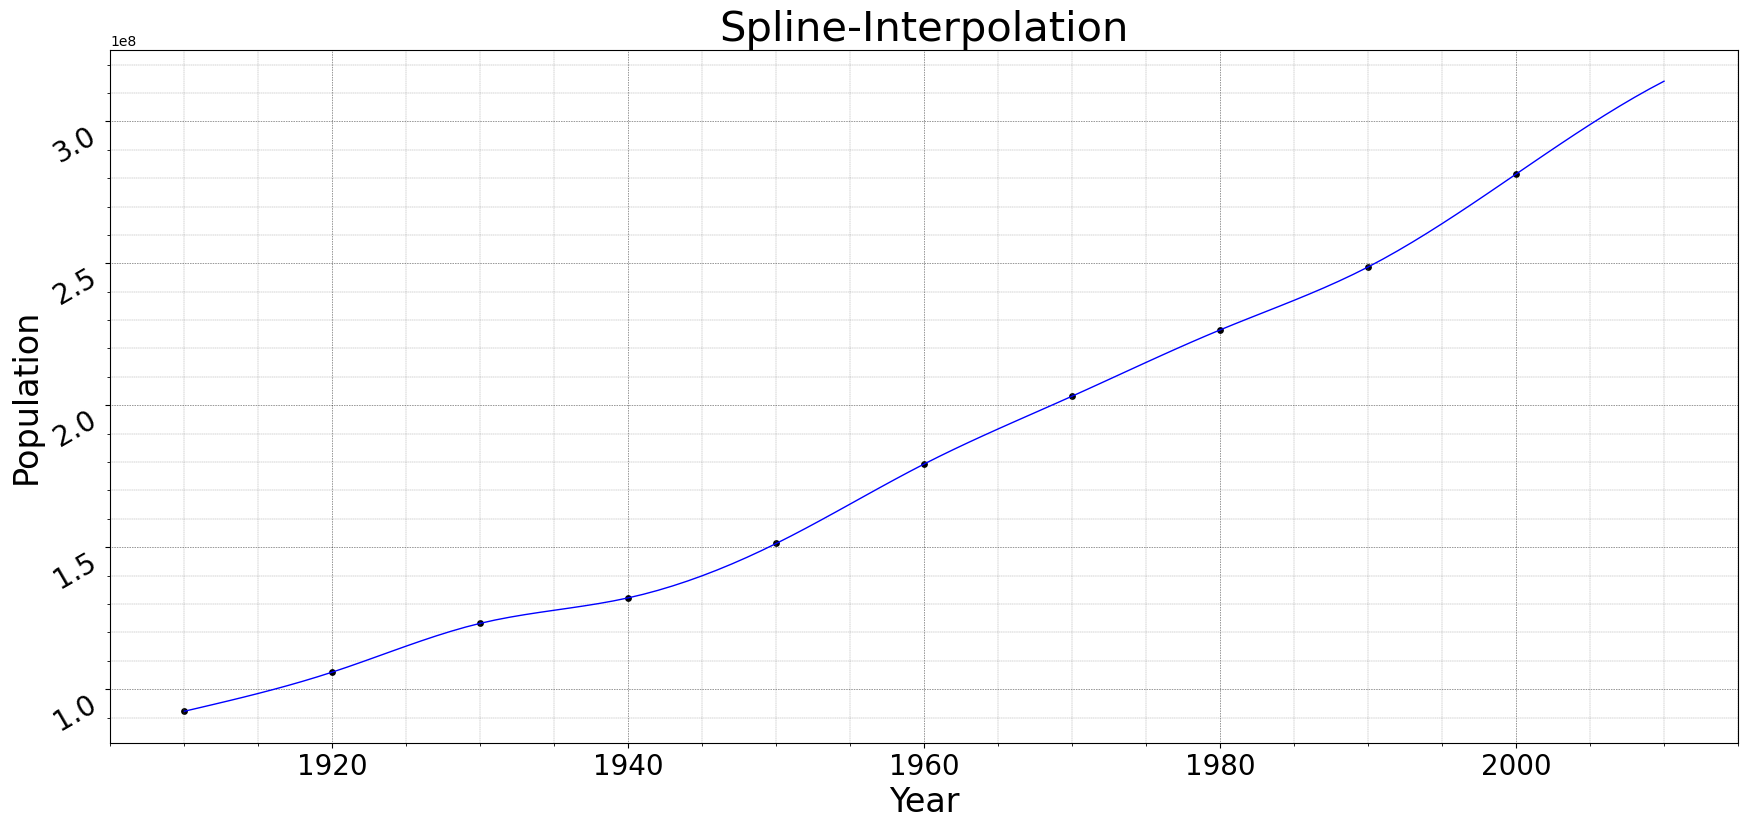

In [ ]:
plt.figure(figsize = (21, 9), dpi = 100)
plt.title("Spline-Interpolation", fontsize = 30)

plt.xlabel("Year", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("Population", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(years, population, s = 15, color = "black")

x = np.arange(years[0], years[len(years) - 1] + 11)
spline = Spline(years, population)
y = []
for point in x:
    y.append(spline(point))
plt.plot(x, y, color='blue', linewidth = 1)

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

print(spline(2010))

### По результатам интерполяции, население США к 2010 году должно было составлять 314.133.939 человек, в то время как в реальности оно составило 308.745.538. Это показывает, что метод даёт очень хорошую экстраполяцию, отклонение от реального результата составляет 1.7% ###

# Метод наименьших квадратов #

Будем аппроксимировать зависимость полиномом второй степени: $ax^2 + bx + c$.

In [ ]:
class Least_Squares:
    def __init__(self, x, f):
        self.x = list(x.copy())
        self.f = list(f.copy())
        self.c = self.coefficients()

    def __call__(self, x_0):
        return self.c[0] + self.c[1] * x_0 + self.c[2] * pow(x_0, 2)

    def coefficients(self):
        n = len(self.x)

        A = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                for k in range(n):
                    A[i, j] += int(self.x[k])**(i+j)

        b = [0, 0, 0]
        for i in range(3):
            for k in range(n):
                b[i] += int(self.f[k]) * int(self.x[k])**i

        return [elem for elem in np.linalg.solve(A, np.array(b))]

312470336.2032471


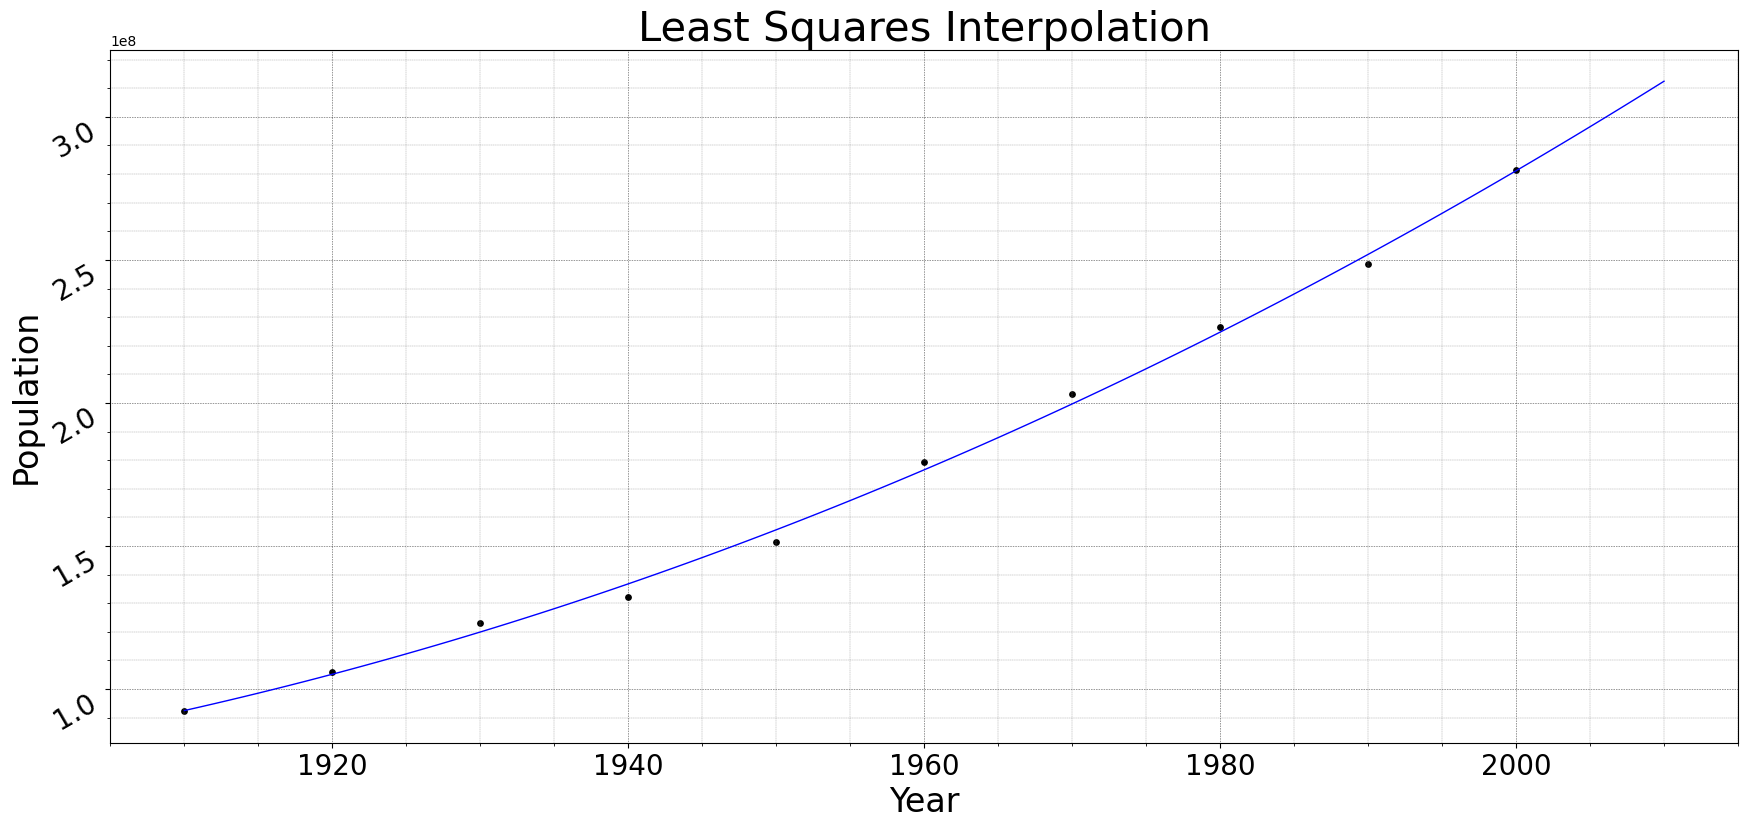

In [ ]:
plt.figure(figsize = (21, 9), dpi = 100)
plt.title("Least Squares Interpolation", fontsize = 30)

plt.xlabel("Year", fontsize = 24)
plt.xticks(fontsize =  20, ha = "center", va = "top")

plt.ylabel("Population", fontsize = 24)
plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.scatter(years, population, s = 15, color = "black")

x = np.arange(years[0], years[len(years) - 1] + 11)
ls = Least_Squares(years, population)
y = []
for point in x:
    y.append(ls(point))
plt.plot(x, y, color='blue', linewidth = 1)

plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
plt.minorticks_on()
plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

print(ls(2010))

По результатам интерполяции, население США к 2010 году должно было составлять 314.133.939 человек, в то время как в реальности оно составило 312.470.336. Это показывает, что метод даёт ещё более хорошуюэкстраполяцию, отклонение от реального результата составляет 1.2%